# Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Dataset

In [3]:
df = pd.read_csv('train.csv')
df.head(4)

,order id,tanggal order,tanggal pengiriman,quantity,jenis customer,jenis product
0,ORD10000,2024-11-15,2024-11-16,2,Regular,Sulit
1,ORD10001,2023-07-27,2023-08-04,5,VIP,Mudah
2,ORD10002,2024-02-06,2024-02-08,3,Regular,Sulit
3,ORD10003,2023-12-28,2023-12-29,9,Regular,Sulit


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order id            1000 non-null   object
 1   tanggal order       1000 non-null   object
 2   tanggal pengiriman  1000 non-null   object
 3   quantity            1000 non-null   int64 
 4   jenis customer      1000 non-null   object
 5   jenis product       1000 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


# Pre-Processing

In [5]:
df['tanggal order'] = pd.to_datetime(df['tanggal order'], format='%Y-%m-%d')
df['tanggal pengiriman'] = pd.to_datetime(df['tanggal pengiriman'], format='%Y-%m-%d')
df.drop(columns=['order id'], inplace=True)
df.rename(columns={
    'quantity': 'kuantitas',
    'jenis product': 'jenis produk'},
    inplace=True
    )

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tanggal order       1000 non-null   datetime64[ns]
 1   tanggal pengiriman  1000 non-null   datetime64[ns]
 2   kuantitas           1000 non-null   int64         
 3   jenis customer      1000 non-null   object        
 4   jenis produk        1000 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 39.2+ KB


In [7]:
df.head()

,tanggal order,tanggal pengiriman,kuantitas,jenis customer,jenis produk
0,2024-11-15,2024-11-16,2,Regular,Sulit
1,2023-07-27,2023-08-04,5,VIP,Mudah
2,2024-02-06,2024-02-08,3,Regular,Sulit
3,2023-12-28,2023-12-29,9,Regular,Sulit
4,2025-01-30,2025-01-31,7,Regular,Mudah


In [8]:
df.duplicated().sum()

1

In [9]:
df[df.duplicated(keep=False)]

,tanggal order,tanggal pengiriman,kuantitas,jenis customer,jenis produk
423,2025-04-30,2025-05-05,10,Occasional,Sedang
785,2025-04-30,2025-05-05,10,Occasional,Sedang


In [10]:
df.isnull().sum()

tanggal order         0
tanggal pengiriman    0
kuantitas             0
jenis customer        0
jenis produk          0
dtype: int64

In [11]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in '{col}': {df[col].unique()}\n")

Unique values in 'jenis customer': ['Regular' 'VIP' 'Occasional' 'New' 'Loyal']

Unique values in 'jenis produk': ['Sulit' 'Mudah' 'Sedang']



In [12]:
for col in df.select_dtypes(include=['int', 'float']).columns:
    print(f"Unique values in '{col}': {df[col].unique()}\n")

Unique values in 'kuantitas': [ 2  5  3  9  7  8  1 10  4  6]



# Feature Engineering dan EDA

In [13]:
df['jarak persiapan produk'] = (df['tanggal pengiriman'] - df['tanggal order']).dt.days

customer_score_map = {
    'Occasional': 0,
    'New': 1,
    'Regular': 2,
    'Loyal': 3,
    'VIP': 4
}

product_score_map = {
    'Mudah': 1,
    'Sedang': 2,
    'Sulit': 3
}

df['jenis customer'] = df['jenis customer'].map(customer_score_map)
df['jenis produk'] = df['jenis produk'].map(product_score_map)

def improved_priority_score(row):
    quantity = row['kuantitas']
    cust_score = row['jenis customer']
    prod_score = row['jenis produk']
    days_left = max(0, 10 - row['jarak persiapan produk'])  

    score = (
        (quantity / 10) * 25 +              
        (cust_score / 4) * 15 +              
        (prod_score / 3) * 20 +              
        (days_left / 10) * 40                
    )
    return round(score, 2)

df['skor output'] = df.apply(improved_priority_score, axis=1)

In [14]:
for column in df.select_dtypes(include=['int', 'float', 'object']).columns:
    print(df[column].value_counts().sort_index(), '\n')

kuantitas
1      83
2     108
3      98
4      81
5     109
6     105
7     103
8     120
9     101
10     92
Name: count, dtype: int64 

jenis customer
0    203
1    198
2    202
3    193
4    204
Name: count, dtype: int64 

jenis produk
1    317
2    333
3    350
Name: count, dtype: int64 

jarak persiapan produk
0    100
1     99
2     87
3    105
4     93
5    110
6    104
7     97
8    104
9    101
Name: count, dtype: int64 

skor output
17.17     1
19.67     1
20.92     1
21.92     1
23.17     1
         ..
93.33     1
95.00     2
96.00     1
97.50     1
100.00    1
Name: count, Length: 493, dtype: int64 



In [15]:
df.describe()

,tanggal order,tanggal pengiriman,kuantitas,jenis customer,jenis produk,jarak persiapan produk,skor output
count,1000,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-07-07 10:35:02.400000,2024-07-11 23:52:48,5.602000,1.997000,2.033000,4.554000,56.831030
min,2023-07-09 00:00:00,2023-07-13 00:00:00,1.000000,0.000000,1.000000,0.000000,17.170000
25%,2024-01-09 00:00:00,2024-01-12 00:00:00,3.000000,1.000000,1.000000,2.000000,45.830000
50%,2024-07-04 00:00:00,2024-07-08 00:00:00,6.000000,2.000000,2.000000,5.000000,56.500000
75%,2025-01-04 06:00:00,2025-01-08 00:00:00,8.000000,3.000000,3.000000,7.000000,67.830000
max,2025-07-06 00:00:00,2025-07-09 00:00:00,10.000000,4.000000,3.000000,9.000000,100.000000
std,NaN,NaN,2.816297,1.421623,0.816442,2.869376,15.441029


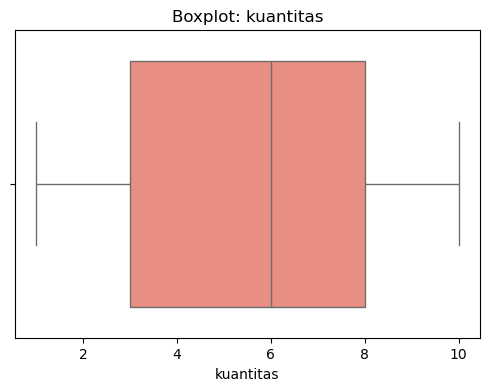

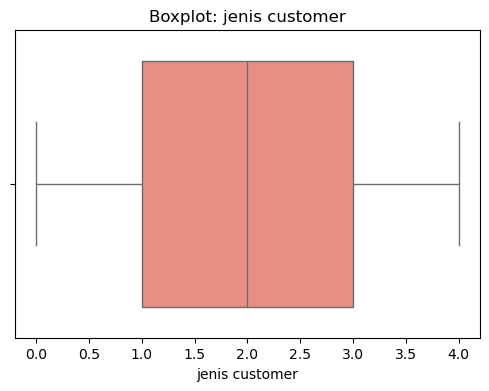

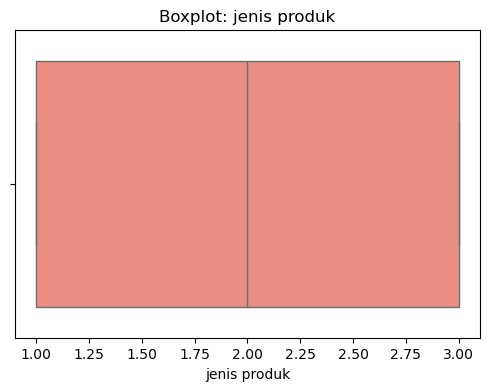

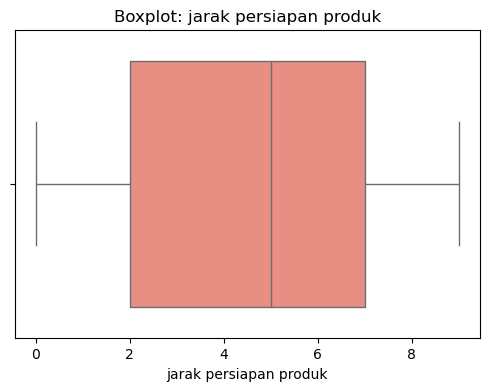

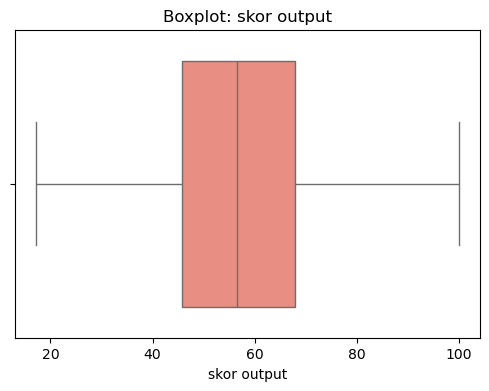

In [16]:
for col in df.select_dtypes(include=['int', 'float']).columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot: {col}')
    plt.show()

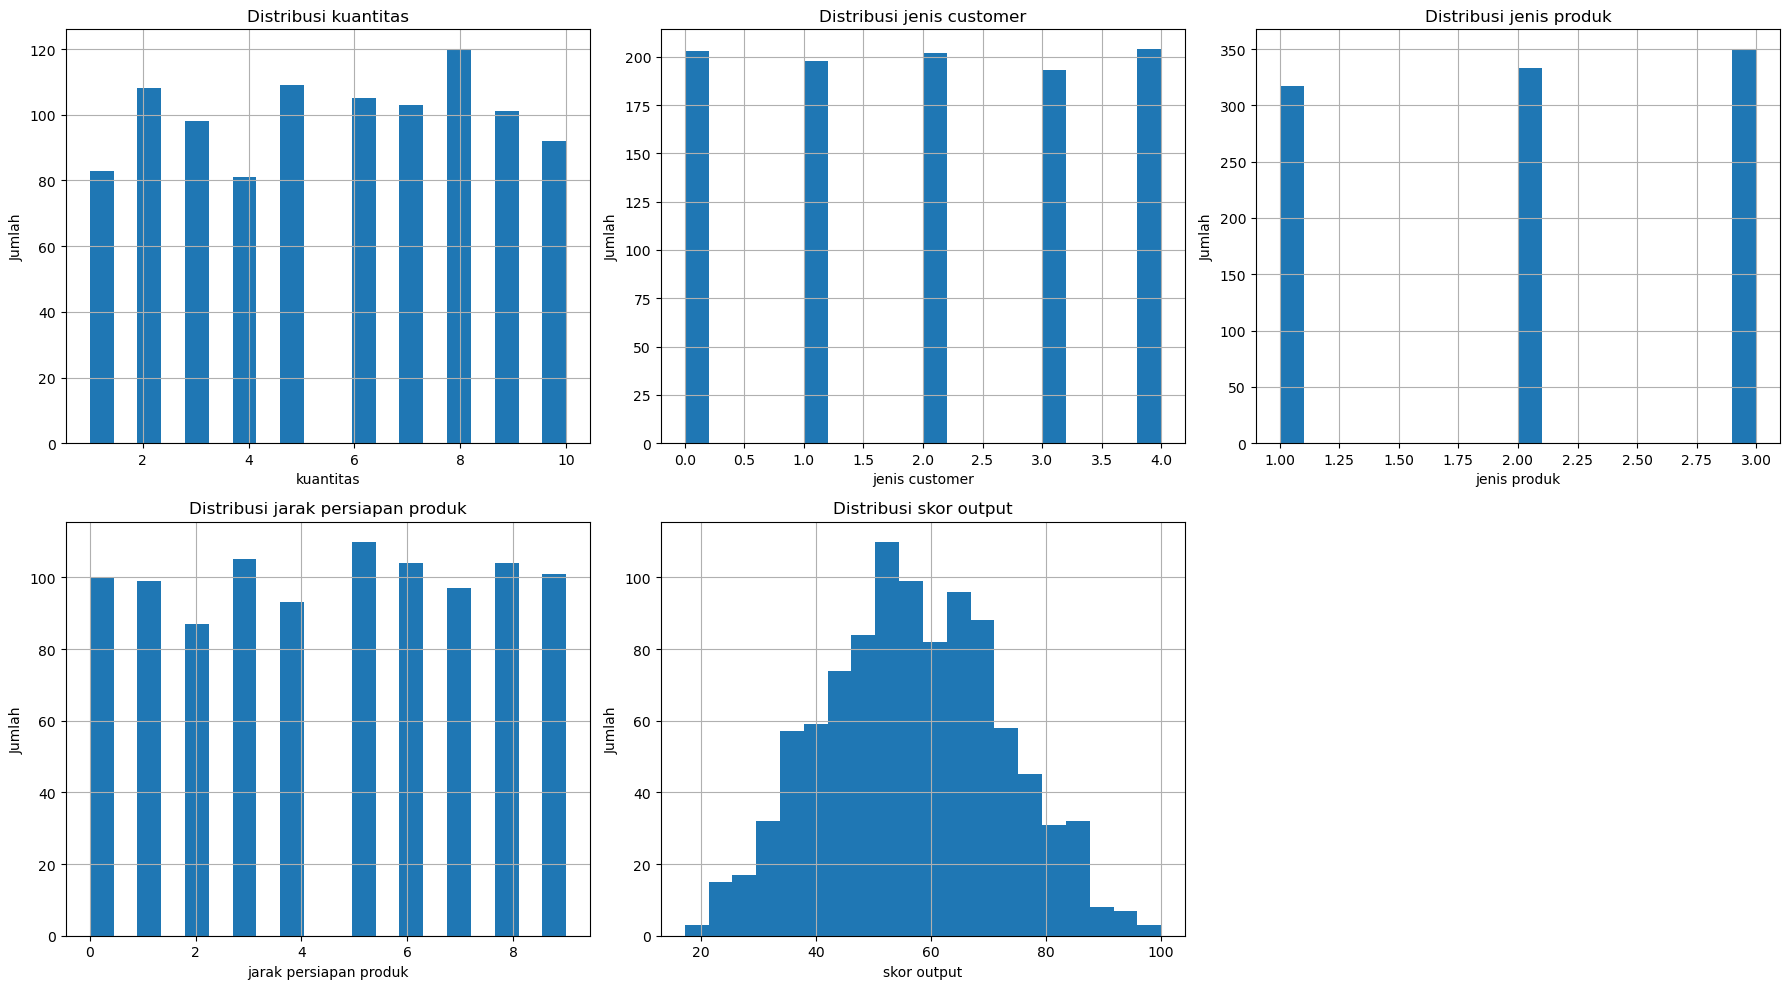

In [17]:
n_cols = 3
n_rows = math.ceil(len(df.select_dtypes(include=['int', 'float']).columns) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axs = axs.flatten()  

for i, col in enumerate(df.select_dtypes(include=['int', 'float']).columns):
    df[col].hist(bins=20, ax=axs[i])
    axs[i].set_title(f'Distribusi {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Jumlah')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


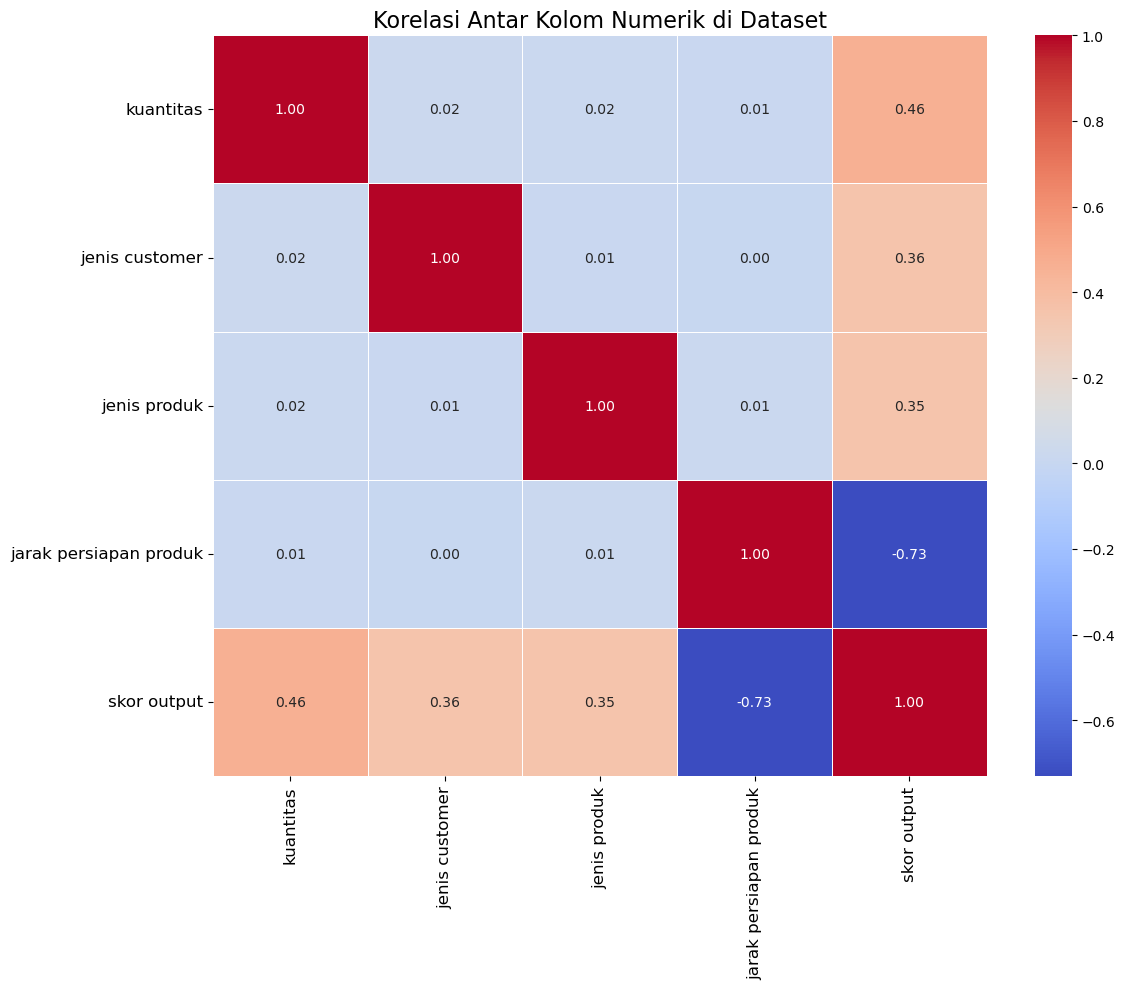

In [18]:
plt.figure(figsize=(12, 10))

correlation_matrix = df.corr(numeric_only=True, method='pearson')

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=0.5,
            linecolor='white')

plt.title('Korelasi Antar Kolom Numerik di Dataset', fontsize=16)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

# Modeling dan Evaluasi

In [19]:
X = df[['kuantitas', 'jenis customer', 'jenis produk', 'jarak persiapan produk']]
y = df["skor output"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Random

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model1 = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10,
    min_samples_split=5, 
    min_samples_leaf=2,
    max_features='sqrt', 
    random_state=42
)
model1.fit(X_train_scaled, y_train)
y_pred = model1.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

MSE: 4.75299806887387
R2 Score: 0.9787855182705714
MAE: 1.7077696667387885
RMSE: 2.180137167444716


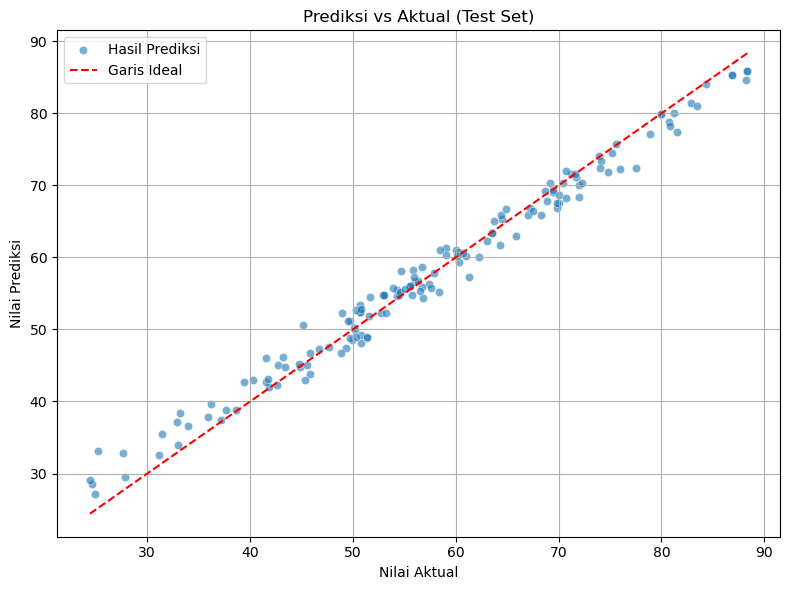

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Hasil Prediksi')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Garis Ideal')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Prediksi vs Aktual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
y_train_pred = model1.predict(X_train_scaled)
y_test_pred = model1.predict(X_test_scaled)

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

Train MSE: 2.1198836371659073
Train R²: 0.991190024958229
Test MSE: 4.75299806887387
Test R²: 0.9787855182705714


In [23]:
scores = cross_val_score(model1, X, y, cv=5, scoring='r2')
print("R² Score Cross-Validation:", scores)
print("Mean R²:", scores.mean())

R² Score Cross-Validation: [0.97685865 0.97840952 0.97650721 0.98294669 0.97676234]
Mean R²: 0.978296884413248


In [24]:
importances = model1.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Fitur': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df)

                    Fitur  Importance
3  jarak persiapan produk    0.550556
0               kuantitas    0.218407
2            jenis produk    0.118473
1          jenis customer    0.112564


In [25]:
hasil1 = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

hasil1['Error'] = hasil1['Actual'] - hasil1['Predicted']
hasil1['Squared Error'] = hasil1['Error'] ** 2
hasil1['Absolute Error'] = abs(hasil1['Error'])
print(hasil1.head(10))

   Actual  Predicted     Error  Squared Error  Absolute Error
0   24.92  27.117794 -2.197794       4.830298        2.197794
1   50.75  48.056255  2.693745       7.256264        2.693745
2   47.67  47.588254  0.081746       0.006682        0.081746
3   49.67  51.175199 -1.505199       2.265623        1.505199
4   59.00  61.314792 -2.314792       5.358260        2.314792
5   54.25  54.689955 -0.439955       0.193560        0.439955
6   51.33  48.767237  2.562763       6.567752        2.562763
7   24.67  28.608921 -3.938921      15.515096        3.938921
8   81.50  77.456137  4.043863      16.352827        4.043863
9   64.50  65.330887 -0.830887       0.690372        0.830887


# Light

In [26]:
from lightgbm import LGBMRegressor

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model2 = LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=40,
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)
model2.fit(X_train_scaled, y_train)
y_pred = model2.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 850, number of used features: 4
[LightGBM] [Info] Start training from score 56.736588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

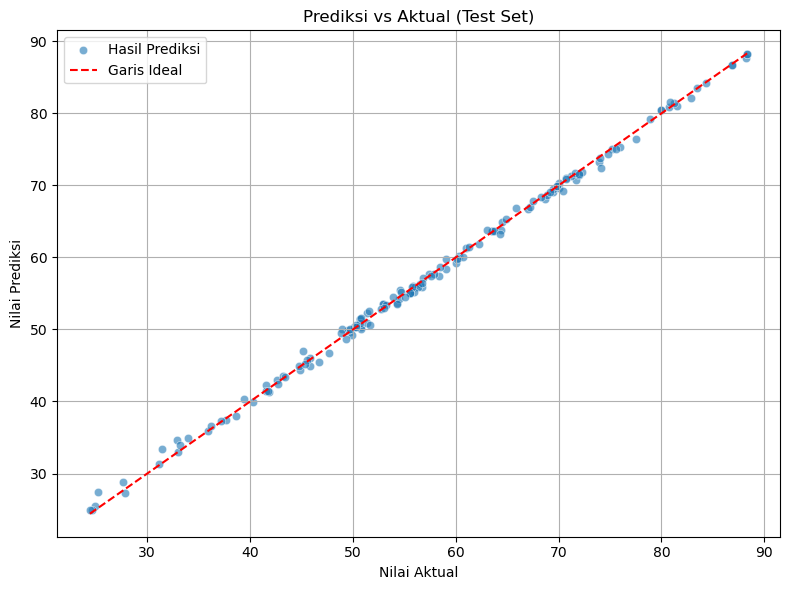

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Hasil Prediksi')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Garis Ideal')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Prediksi vs Aktual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
y_train_pred = model2.predict(X_train_scaled)
y_test_pred = model2.predict(X_test_scaled)

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

Train MSE: 0.17517587716956676
Train R²: 0.9992719906514079
Test MSE: 0.38856007733874787
Test R²: 0.9982657050261665


In [30]:
scores = cross_val_score(model2, X, y, cv=5, scoring='r2')
print("R² Score Cross-Validation:", scores)
print("Mean R²:", scores.mean())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 4
[LightGBM] [Info] Start training from score 56.646338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [31]:
importances = model2.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Fitur': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df)

                    Fitur  Importance
3  jarak persiapan produk        2250
0               kuantitas        2181
1          jenis customer        2080
2            jenis produk        1205


In [32]:
hasil2 = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

hasil2['Error'] = hasil2['Actual'] - hasil2['Predicted']
hasil2['Squared Error'] = hasil2['Error'] ** 2
hasil2['Absolute Error'] = abs(hasil2['Error'])
print(hasil2.head(10))

   Actual  Predicted     Error  Squared Error  Absolute Error
0   24.92  25.486476 -0.566476       0.320896        0.566476
1   50.75  50.404309  0.345691       0.119502        0.345691
2   47.67  46.748778  0.921222       0.848650        0.921222
3   49.67  49.606471  0.063529       0.004036        0.063529
4   59.00  58.420319  0.579681       0.336030        0.579681
5   54.25  53.660582  0.589418       0.347414        0.589418
6   51.33  50.892158  0.437842       0.191705        0.437842
7   24.67  24.925113 -0.255113       0.065082        0.255113
8   81.50  81.003128  0.496872       0.246882        0.496872
9   64.50  64.870439 -0.370439       0.137225        0.370439


# XGB

In [33]:
from xgboost import XGBRegressor

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model3 = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)
model3.fit(X_train_scaled, y_train)
y_pred = model3.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

MSE: 1.4668025756750938
R2 Score: 0.9934530887680939
MAE: 0.8048964096069335
RMSE: 1.2111162519242709


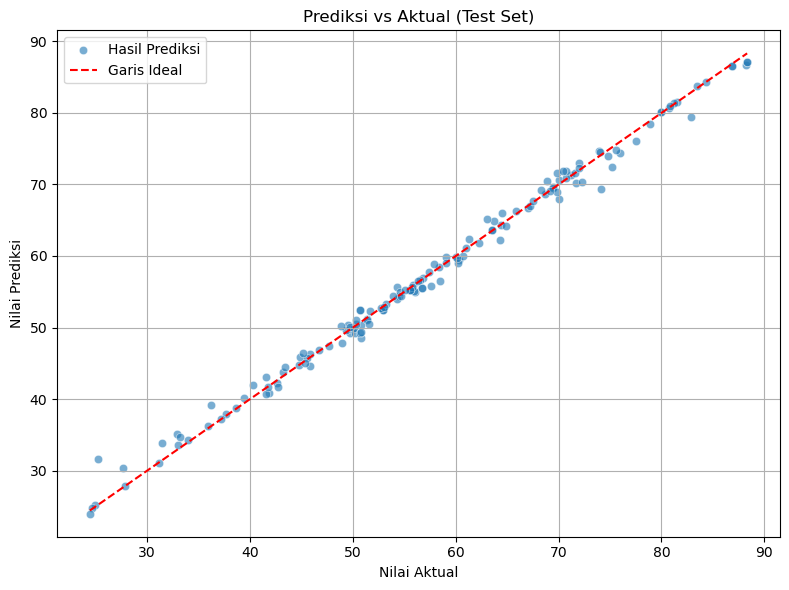

In [35]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Hasil Prediksi')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Garis Ideal')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Prediksi vs Aktual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
y_train_pred = model3.predict(X_train_scaled)
y_test_pred = model3.predict(X_test_scaled)

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

Train MSE: 0.06556902488699007
Train R²: 0.9997275032163842
Test MSE: 1.4668025756750938
Test R²: 0.9934530887680939


In [37]:
scores = cross_val_score(model3, X, y, cv=5, scoring='r2')
print("R² Score Cross-Validation:", scores)
print("Mean R²:", scores.mean())

R² Score Cross-Validation: [0.99377812 0.9907378  0.99252664 0.99377837 0.99320918]
Mean R²: 0.9928060230729201


In [38]:
importances = model3.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Fitur': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df)

                    Fitur  Importance
3  jarak persiapan produk    0.440976
2            jenis produk    0.246038
0               kuantitas    0.157919
1          jenis customer    0.155066


In [39]:
hasil3 = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

hasil3['Error'] = hasil3['Actual'] - hasil3['Predicted']
hasil3['Squared Error'] = hasil3['Error'] ** 2
hasil3['Absolute Error'] = abs(hasil3['Error'])
print(hasil3.head(10))

   Actual  Predicted     Error  Squared Error  Absolute Error
0   24.92  25.243538 -0.323538       0.104677        0.323538
1   50.75  48.540546  2.209454       4.881685        2.209454
2   47.67  47.414043  0.255957       0.065514        0.255957
3   49.67  49.236671  0.433329       0.187774        0.433329
4   59.00  59.870605 -0.870605       0.757954        0.870605
5   54.25  55.636654 -1.386654       1.922809        1.386654
6   51.33  51.138451  0.191549       0.036691        0.191549
7   24.67  24.834660 -0.164660       0.027113        0.164660
8   81.50  81.584846 -0.084846       0.007199        0.084846
9   64.50  66.019096 -1.519096       2.307654        1.519096


# Perbandingan Grafik Antar Model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 850, number of used features: 4
[LightGBM] [Info] Start training from score 56.736588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

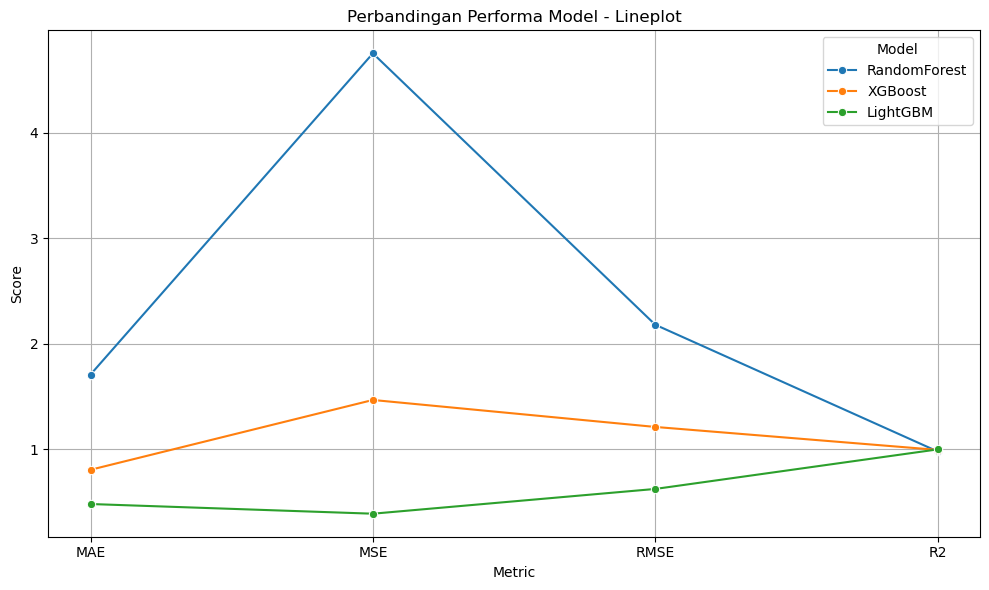

In [40]:
models = {
    'RandomForest':  RandomForestRegressor(
    n_estimators=200, 
    max_depth=10,
    min_samples_split=5, 
    min_samples_leaf=2,
    max_features='sqrt', 
    random_state=42
),
    'XGBoost': XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
),
    'LightGBM': LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=40,
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

results_df = pd.DataFrame(results)

results_long = pd.melt(results_df, id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_long, x='Metric', y='Score', hue='Model', marker='o')
plt.title("Perbandingan Performa Model - Lineplot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
joblib.dump(model1, 'model_random_forest.pkl')
joblib.dump(model3, 'model_xgboost.pkl')
joblib.dump(model2, 'model_lightgbm.pkl')

['model_lightgbm.pkl']